Перевод терминов на русский язык осуществлён в соответствии со статьями [[1](http://neerc.ifmo.ru/wiki/index.php?title=Обучение_с_подкреплением)], [[2](https://cyberleninka.ru/article/n/realizatsiya-metodov-obucheniya-s-podkrepleniem-na-osnove-temporalnyh-razlichiy-i-multiagentnogo-podhoda-dlya-intellektualnyh-sistem)].

# Обзор

In [1]:
import gym
import numpy
import matplotlib.pyplot as pyplot
from math import degrees
import random

Рассмотрим классическое окружение из модуля Gym - каретку с шестом.

>A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

<a href="http://www.youtube.com/watch?feature=player_embedded&v=XiigTGKZfks" target="_blank"><img src="http://img.youtube.com/vi/XiigTGKZfks/0.jpg" width="240" height="180" border="10" /></a>

In [2]:
environment = gym.make("CartPole-v0")

Посмотрим, что из себя представляет пространство состояний.

In [3]:
print(environment.observation_space)

Box(4,)


Таким образом, состояние - это вектор из четырёх значений, например

In [4]:
environment.reset()

array([ 0.04236681,  0.03526723, -0.02163297,  0.01380899])

In [5]:
print(environment.observation_space.sample())

[-2.4486332e+00  1.8600665e+38 -2.2104125e-01 -2.4850162e+38]


Согласно данным из [GitHub](https://gist.github.com/gsurma/53b4ee9d34f6c42e44decc39f464d785#file-observation_and_action_spaces), это соответственно позиция каретки, скорость движения каретки, угол шеста и скорость верхушки шеста.

Посмотрим на диапазоны координат этого вектора.

In [6]:
print(environment.observation_space.high)
print(environment.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


(на самом деле подразумевается, что границы скорости движения каретки и скорости движения верхушки шеста бесконечны).

Также обратим внимание, что пространство состояний непрерывно.

Взглянем теперь на пространство действий.

In [7]:
print(environment.action_space)

Discrete(2)


Действительно, на каждом этапе мы можем принять решение - либо приложить силу влево (0), либо вправо (1).

Наконец, посмотрим на границы наград.

In [8]:
print(environment.reward_range)

(-inf, inf)


В действительности при переходе в каждое состояние награда равна 1. Поэтому ценность (return) в итоге будет равна длительности эпизода в кадрах.

Теперь попробуем написать раличных ботов.

## Агент с выбором случайного действия

На каждом этапе будем выбирать действие случайным образом

Средняя ценность: 22.3555


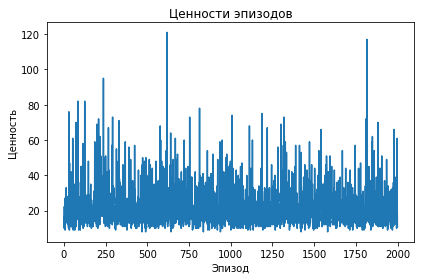

In [9]:
random_episode_returns = []
for episode in range(2000):
    episode_return = 0
    observation = environment.reset()
    terminated = False
    while not terminated:
        # Выбор действия
        action = environment.action_space.sample()
        observation, reward, terminated, _ = environment.step(action)
        episode_return += reward
    random_episode_returns.append(episode_return)
environment.close()

pyplot.plot(random_episode_returns)
pyplot.title("Ценности эпизодов")
pyplot.xlabel("Эпизод")
pyplot.ylabel("Ценность")
pyplot.tight_layout()

print("Средняя ценность: " + str(numpy.array(random_episode_returns).mean()))

Удручающая картина.

## Агент с поочерёдным выбором действия

На каждом этапе будем выбирать действие, отличное от предыдущего

Средняя ценность: 37.745


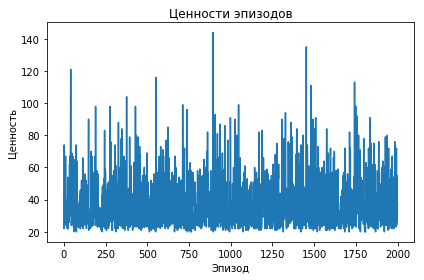

In [10]:
switch_episode_returns = []
for episode in range(2000):
    episode_return = 0
    observation = environment.reset()
    terminated = False
    previous_action = 1
    while not terminated:
        # Выбор действия
        action = 1 - previous_action
        previous_action = 1 - previous_action
        observation, reward, terminated, _ = environment.step(action)
        episode_return += reward
    switch_episode_returns.append(episode_return)
environment.close()

pyplot.plot(switch_episode_returns)
pyplot.title("Ценности эпизодов")
pyplot.xlabel("Эпизод")
pyplot.ylabel("Ценность")
pyplot.tight_layout()

print("Средняя ценность: " + str(numpy.array(switch_episode_returns).mean()))

Уже получше, но всё равно недостаточно, чтобы удерживать шест в вертикальном положении. Основная причина тому - различные начальные состояния.

## Агент с выбором действия в зависимости от угла шеста

Будем действовать так: если угол шеста отрицательный, то выбираем действие 0 (влево), в противном случае - 1 (вправо).

Средняя ценность: 42.283


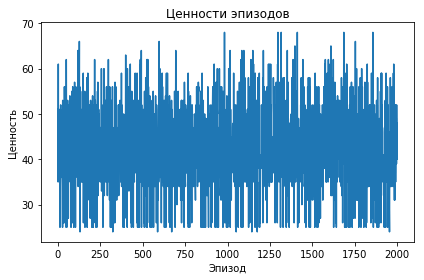

In [11]:
angle_episode_returns = []
for episode in range(2000):
    episode_return = 0
    observation = environment.reset()
    terminated = False
    while not terminated:
        # Выбор действия
        action = 0 if observation[2] < 0 else 1
        observation, reward, terminated, _ = environment.step(action)
        episode_return += reward
    angle_episode_returns.append(episode_return)
environment.close()

pyplot.plot(angle_episode_returns)
pyplot.title("Ценности эпизодов")
pyplot.xlabel("Эпизод")
pyplot.ylabel("Ценность")
pyplot.tight_layout()

print("Средняя ценность: " + str(numpy.array(angle_episode_returns).mean()))

Шест раскачивается до тех пор, пока его угол не превысит по модулю 24 градуса. Далее состояния считаются терминальными.

Надо научиться удерживать шест в вертикальном положении.

# Табличные методы

Для начала определимся с пространством состояний. Для табличных методов необходимо, чтобы пространство состояний было конечным. Поэтому состояния будем определять, исходя из того, какой промежуток занимает каждое значение вектора исходного непрерывного состояния.

Для простоты при определении состояния будем полагаться только на значение угла шеста и скорости движения верхушки шеста. Исключим из рассмотрения позицию каретки и скорость движения верхушки шеста, чтобы количество всевозможных состояний не сильно разрасталось.

Создадим несколько вспомогательных переменных и функций.

In [9]:
# Общее число возможных состояний.
states_count = 484
# Общее число возможных действий.
actions_count = environment.action_space.n

# Преобразует возвращаемые средой значения в номер состояния.
def get_state(observation):
    pole_angle = observation[2]
    scaled_pole_angle = degrees(pole_angle)
    if scaled_pole_angle < -10:
        pole_angle_state = 0
    elif scaled_pole_angle < 10:
        pole_angle_state = int(scaled_pole_angle + 10) + 1
    else:
        pole_angle_state = 21
    
    pole_velocity = observation[3]
    scaled_pole_velocity = 5 * pole_velocity
    if scaled_pole_velocity < -10:
        pole_velocity_state = 0
    elif scaled_pole_velocity < 10:
        pole_velocity_state = int(scaled_pole_velocity + 10) + 1
    else:
        pole_velocity_state = 21
    
    return pole_angle_state * 22 + pole_velocity_state

# argmax, отличный от numpy.argmax. При нескольких максимальных значениях он возвращает
# индекс случайного из них (а не первого, как в numpy).
def argmax(a):
    return random.choice(list(filter(lambda i: a[i] == max(a), range(len(a)))))

# Возвращает argmax от action_values.
def greedy(action_values):
    return argmax(action_values)

# Возвращает argmax от action_values с вероятностью epsilon и случайное число
# от 0 до len(action_values) с вероятностью 1 - epsilon.
def epsilon_greedy(action_values, epsilon):
    return greedy(action_values) if random.random() > epsilon \
        else random.randrange(0, len(action_values))

# Отображает несколько scatter plots по разным параметрам.
def visualize(episode_returns_dataframe):
    figure, axes = pyplot.subplots(3, 2, figsize=(12, 12))
    episode_returns_dataframe.plot.scatter(x="$\\alpha$", y="Episode return",
                                           ax=axes[0, 0])
    episode_returns_dataframe.plot.scatter(x="$\\epsilon$", y="Episode return",
                                           ax=axes[0, 1])
    episode_returns_dataframe.plot.scatter(x="$\\alpha$", y="$\\epsilon$",
                                           s=episode_returns_dataframe
                                               .groupby(["$\\alpha$", "$\\epsilon$"])
                                               ["Episode return"].transform('min'),
                                           ax=axes[1, 0])
    episode_returns_dataframe.plot.scatter(x="$\\alpha$", y="$\\epsilon$",
                                           s=episode_returns_dataframe
                                               .groupby(["$\\alpha$", "$\\epsilon$"])
                                               ["Episode return"].transform('max'),
                                           ax=axes[1, 1])
    episode_returns_dataframe.plot.scatter(x="$\\alpha$", y="$\\epsilon$",
                                           s=episode_returns_dataframe
                                               .groupby(["$\\alpha$", "$\\epsilon$"])
                                               ["Episode return"].transform('mean'),
                                           ax=axes[2, 0])
    episode_returns_dataframe.plot.scatter(x="$\\alpha$", y="$\\epsilon$",
                                           s=episode_returns_dataframe
                                               .groupby(["$\\alpha$", "$\\epsilon$"])
                                               ["Episode return"].transform('var')/10,
                                           ax=axes[2, 1])
    axes[0, 0].set_title("Ценности при разных $\\alpha$")
    axes[0, 0].set_ylabel("Ценность эпизода")
    axes[0, 1].set_title("Ценности при разных $\\epsilon$")
    axes[0, 1].set_ylabel("Ценность эпизода")
    axes[1, 0].set_title("Наименьшие ценности")
    axes[1, 1].set_title("Наибольшие ценности")
    axes[2, 0].set_title("Средние ценности")
    axes[2, 1].set_title("Дисперсия ценностей")
    pyplot.tight_layout()

## Монте-Карло

In [10]:
# Генерирует эпизод и возвращает последовательность (S, A, R) этого эпизода.
def generate_episode(policy, render):
    episode = []
    observation = environment.reset()
    state = get_state(observation)
    terminated = False
    while not terminated:
        if render:
            environment.render()
        action = numpy.random.choice(range(actions_count), p=policy[state])
        observation, reward, terminated, _ = environment.step(action)
        episode.append((state, action, reward))
        state = get_state(observation)
    environment.close()
    return episode

def appears(state_action_pair, episode):
    return state_action_pair in list(map(lambda a: a[:2], episode))

def average(l):
    return sum(l) / len(l)

In [11]:
# Табличный on-policy алгоритм Монте-Карло.
def monte_carlo(gamma, epsilon, q, episodes_count, render=False):
    episode_returns = []
    policy = [[1/actions_count] * actions_count] * states_count
    returns = [[[]] * actions_count] * states_count
    for i in range(episodes_count):
        episode = generate_episode(policy, render)
        current_return = 0
        for step in reversed(range(len(episode))):
            (state, action, reward) = episode[step]
            current_return = gamma * current_return + reward
            if not appears((state, action), episode[:step]):
                returns[state][action].append(current_return)
                q[state][action] = average(returns[state][action])
                greedy_action = greedy(q[state])
                for action in range(actions_count):
                    policy[state][action] \
                        = 1 - epsilon + epsilon / actions_count \
                        if action == greedy_action \
                        else epsilon / actions_count
        episode_returns.append(current_return)
    return episode_returns

In [152]:
%%time
gamma = 1
epsilon = 0.5
learning_iterations_count = 2000
validation_episodes_count = 100

q = numpy.zeros((states_count, environment.action_space.n))
monte_carlo_min_episode_returns = []

for learning_iteration in range(learning_iterations_count):
    monte_carlo(gamma, epsilon, q, 1, render=False)
    min_episode_return = min(q_greedy(gamma, q, validation_episodes_count, render=False))
    monte_carlo_min_episode_returns.append(min_episode_return)
    if (learning_iteration + 1) % (learning_iterations_count // 10) == 0:
        print("Learning iteration " + str(learning_iteration + 1) + " is completed.")

Learning iteration 200 is completed.
Learning iteration 400 is completed.
Learning iteration 600 is completed.
Learning iteration 800 is completed.
Learning iteration 1000 is completed.
Learning iteration 1200 is completed.
Learning iteration 1400 is completed.
Learning iteration 1600 is completed.
Learning iteration 1800 is completed.
Learning iteration 2000 is completed.
CPU times: user 17min 57s, sys: 5.96 s, total: 18min 3s
Wall time: 18min 4s


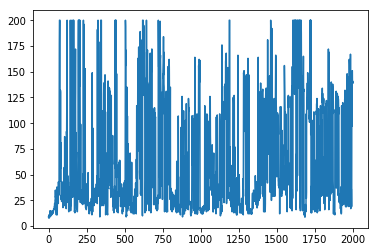

In [153]:
pyplot.plot(monte_carlo_min_episode_returns)

## Sarsa

Правило обновления значений $Q$ для алгоритма Sarsa:

$$Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha\Big[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)\Big]$$

In [10]:
# Табличный алгоритм Sarsa.
def sarsa(alpha, gamma, epsilon, q, episodes, render=False):
    episode_returns = []
    for episode in range(episodes):
        episode_return = 0
        current_discount = 1
        observation = environment.reset()
        state1 = get_state(observation)
        action1 = epsilon_greedy(q[state1], epsilon)
        terminated = False
        while not terminated:
            if render:
                environment.render()
            observation, reward, terminated, _ \
                = environment.step(action1)
            state2 = get_state(observation)
            action2 = epsilon_greedy(q[state2], epsilon)
            # Q update
            q[state1][action1] \
                += alpha * (reward + gamma * q[state2][action2]
                            - q[state1][action1])
            state1 = state2
            action1 = action2
            episode_return += current_discount * reward
            current_discount *= gamma
        episode_returns.append(episode_return)
    environment.close()
    return episode_returns

Для валидации нашей модели нам потербуется выбирать действия с наибольшим значением в q-таблице, т.е. с жадным выбором действия.

In [11]:
# Табличный алгоритм с жадным выбором действия.
def q_greedy(gamma, q, episodes, render=True):
    episode_returns = []
    for episode in range(episodes):
        episode_return = 0
        current_discount = 1
        observation = environment.reset()
        state = get_state(observation)
        terminated = False
        while not terminated:
            if render:
                environment.render()
            action = greedy(q[state])
            observation, reward, terminated, _ = environment.step(action)
            state = get_state(observation)
            episode_return += current_discount * reward
            current_discount *= gamma
        episode_returns.append(episode_return)
    environment.close()
    return episode_returns

Посмотрим на ценности при различных гиперпараметрах $\alpha$ и $\epsilon$. Будем по несколько раз обучать модель с нуля и проводить валидацию, запуская несколько жадных эпизодов и записывая полученные ценности в таблицу. Для облегчения работы с полученными данными воспользуемся библиотекой ```pandas```.

In [12]:
import pandas

In [15]:
%%time
gamma = 1
learning_episodes_count = 1000
validation_episodes_count = 100

sarsa_returns_dataframe1 = pandas.DataFrame(columns=["$\\alpha$", "$\\epsilon$",
                                                     "Episode return"])

for alpha in numpy.append(numpy.arange(0.1, 1, 0.1), 1):
    for epsilon in numpy.arange(0.1, 1, 0.1):
        for iteration in range(10):
            q = numpy.zeros((states_count, environment.action_space.n))
            sarsa(alpha, gamma, epsilon, q, learning_episodes_count, render=False)
            episode_returns = q_greedy(gamma, q, validation_episodes_count, render=False)
            for episode_return in episode_returns:
                sarsa_returns_dataframe1.loc[len(sarsa_returns_dataframe1) + 1] \
                    = [alpha, epsilon, episode_return]
    print("Completed evaluating returns with alpha=" + str(alpha))

Completed evaluating returns with alpha=0.1
Completed evaluating returns with alpha=0.2
Completed evaluating returns with alpha=0.30000000000000004
Completed evaluating returns with alpha=0.4
Completed evaluating returns with alpha=0.5
Completed evaluating returns with alpha=0.6
Completed evaluating returns with alpha=0.7000000000000001
Completed evaluating returns with alpha=0.8
Completed evaluating returns with alpha=0.9
Completed evaluating returns with alpha=1.0
CPU times: user 35min 48s, sys: 1.37 s, total: 35min 49s
Wall time: 35min 49s


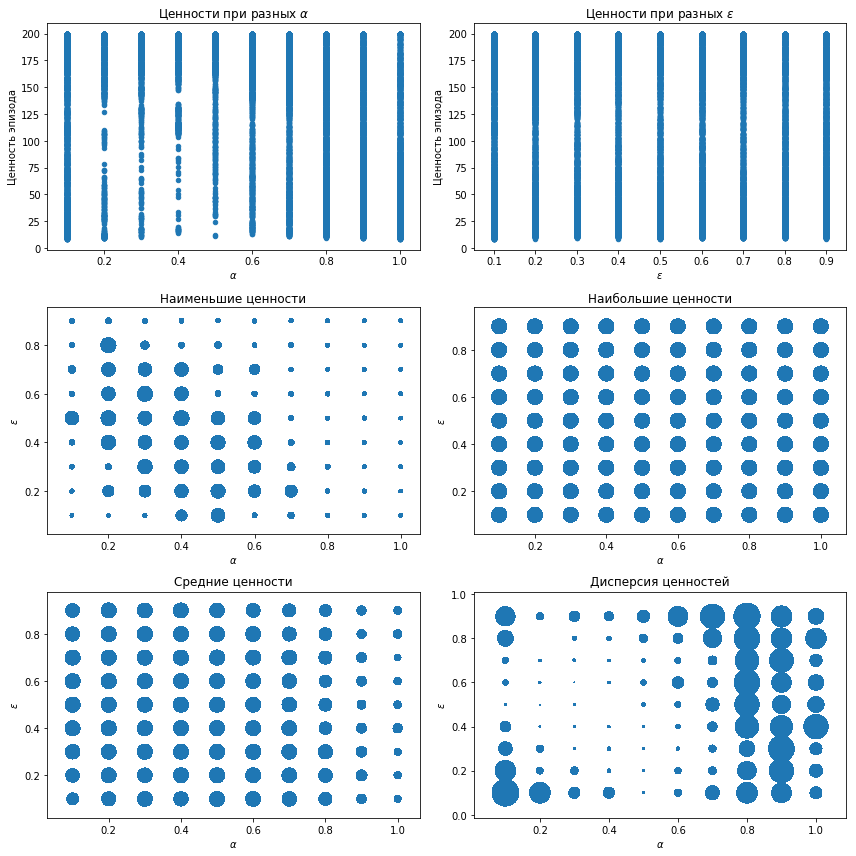

In [24]:
visualize(sarsa_returns_dataframe1)

Неплохой результат. Видна чёткая градация значений средних ценностей при изменении параметров $\alpha$ и $\epsilon$. Это значит, что мы хорошо дискретизировали исходное пространство состояний.

Посмотрим теперь, насколько быстро обучается алгоритм и насколько хороша стратегия, к которой он сходится.

После каждого обучающего эпизода будем проводить валидацию, запуская несколько жадных эпизодов. Будем повторять эту процедуру несколько раз. Построим график зависимости наименьшей ценности валидационных эпизодов от номера обучающего эпизода.

In [ ]:
%%time
alpha = 0.1
gamma = 1
epsilon = 0.5
learning_iterations_count = 2000
validation_episodes_count = 100

q = numpy.zeros((states_count, environment.action_space.n))
sarsa_min_episode_returns = []

for learning_iteration in range(learning_iterations_count):
    sarsa(alpha, gamma, epsilon, q, 1, render=False)
    min_episode_return = numpy.array(q_greedy(gamma, q,
                                               validation_episodes_count,
                                               render=False)).min()
    sarsa_min_episode_returns.append(min_episode_return)
    if (learning_iteration + 1) % (learning_iterations_count // 10) == 0:
        print("Learning iteration " + str(learning_iteration + 1) + " is completed.")

Learning iteration 200 is completed.
Learning iteration 400 is completed.
Learning iteration 600 is completed.
Learning iteration 800 is completed.
Learning iteration 1000 is completed.
Learning iteration 1200 is completed.
Learning iteration 1400 is completed.
Learning iteration 1600 is completed.
Learning iteration 1800 is completed.


In [ ]:
pyplot.plot(sarsa_min_episode_returns)
pyplot.title("Скорость обучения")
pyplot.xlabel("Эпизод эпизода")
pyplot.ylabel("Минимальная ценность")
pyplot.tight_layout()
print("Средняя минимальная ценность: " + str(numpy.array(sarsa_min_episode_returns).mean()))

Видим, что даже спустя большое количество обучающих эпизодов график иногда "проваливается". Но вообще, задача считается решённой, если мы более 195 шагов остаёмся в нетерминальном состоянии, и так 100 эпизодов подряд.

Теперь, когда мы знаем необходимое количество обучающих эпизодов, попробуем определить, всегда ли алгоритм сходится к оптимальной стратегии.

Будем 50 раз запускать наш алгоритм, каждый раз обучая его с нуля.

In [0]:
%%time
sarsa_returns_dataframe2 = pandas.DataFrame(columnяs=["Iteration", "Episode return"])

alpha = 0.1
gamma = 1
epsilon = 0.5
learning_episodes_count = 15000
validation_episodes_count = 100

qs = []
for iteration in range(50):
    q = numpy.zeros((states_count, environment.action_space.n))
    sarsa(alpha, gamma, epsilon, q, learning_episodes_count, render=False)
    episode_returns = q_greedy(gamma, q, validation_episodes_count, render=False)
    for episode_return in episode_returns:
        sarsa_returns_dataframe2.loc[len(sarsa_returns_dataframe2) + 1] \
            = [iteration + 1, episode_return]
    qs.append(q)
    print("Learning iteration " + str(iteration + 1) + " is completed.")

Learning iteration 1 is completed.
Learning iteration 2 is completed.
Learning iteration 3 is completed.
Learning iteration 4 is completed.
Learning iteration 5 is completed.
Learning iteration 6 is completed.
Learning iteration 7 is completed.
Learning iteration 8 is completed.
Learning iteration 9 is completed.
Learning iteration 10 is completed.
Learning iteration 11 is completed.
Learning iteration 12 is completed.
Learning iteration 13 is completed.
Learning iteration 14 is completed.
Learning iteration 15 is completed.
Learning iteration 16 is completed.
Learning iteration 17 is completed.
Learning iteration 18 is completed.
Learning iteration 19 is completed.
Learning iteration 20 is completed.
Learning iteration 21 is completed.
Learning iteration 22 is completed.
Learning iteration 23 is completed.
Learning iteration 24 is completed.
Learning iteration 25 is completed.
Learning iteration 26 is completed.
Learning iteration 27 is completed.
Learning iteration 28 is completed.
L

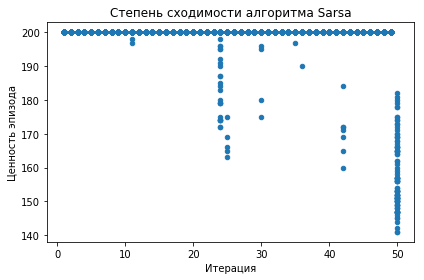

In [0]:
ax = sarsa_returns_dataframe2.plot.scatter(x="Iteration", y="Episode return")
ax.set_title("Степень сходимости алгоритма Sarsa")
ax.set_xlabel("Итерация")
ax.set_ylabel("Ценность эпизода")
pyplot.tight_layout()

Видим, что, несмотря на большое количество обучающих эпизодов, стратегия всё же не всегда сходится к оптимальной.

## Q-learning

Правило обновления значений $Q$ для алгоритма Q-learning:

$$Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha\Big[R_{t+1} + \gamma \max_{a}Q(S_{t+1}, a) - Q(S_t, A_t)\Big]$$

In [29]:
# Табличный алгоритм Q-learning.
def q_learning(alpha, gamma, epsilon, q, episodes, render=False):
    episode_returns = []
    for episode in range(episodes):
        episode_return = 0
        current_discount = 1
        observation = environment.reset()
        state1 = get_state(observation)
        terminated = False
        while not terminated:
            if render:
                environment.render()
            action = epsilon_greedy(q[state1], epsilon)
            observation, reward, terminated, _ \
                = environment.step(action)
            state2 = get_state(observation)
            # Q update
            q[state1][action] \
                += alpha * (reward + gamma * max(q[state2])
                            - q[state1][action])
            state1 = state2
            episode_return += current_discount * reward
            current_discount *= gamma
        episode_returns.append(episode_return)
    environment.close()
    return episode_returns

Осуществим те же операции, что и с предыдущим алгоритмом.

In [30]:
%%time
gamma = 1
learning_episodes_count = 1000
validation_episodes_count = 100

q_learning_returns_dataframe1 = pandas.DataFrame(columns=["$\\alpha$", "$\\epsilon$",
                                                          "Episode return"])

for alpha in numpy.append(numpy.arange(0.1, 1, 0.1), 1):
    for epsilon in numpy.arange(0.1, 1, 0.1):
        for iteration in range(10):
            q = numpy.zeros((states_count, environment.action_space.n))
            q_learning(alpha, gamma, epsilon, q, learning_episodes_count, render=False)
            episode_returns = q_greedy(gamma, q, validation_episodes_count, render=False)
            for episode_return in episode_returns:
                q_learning_returns_dataframe1.loc[len(q_learning_returns_dataframe1) + 1] \
                    = [alpha, epsilon, episode_return]
    print("Completed evaluating returns with alpha=" + str(alpha))

Completed evaluating returns with alpha=0.1
Completed evaluating returns with alpha=0.2
Completed evaluating returns with alpha=0.30000000000000004
Completed evaluating returns with alpha=0.4
Completed evaluating returns with alpha=0.5
Completed evaluating returns with alpha=0.6
Completed evaluating returns with alpha=0.7000000000000001


KeyboardInterrupt: 

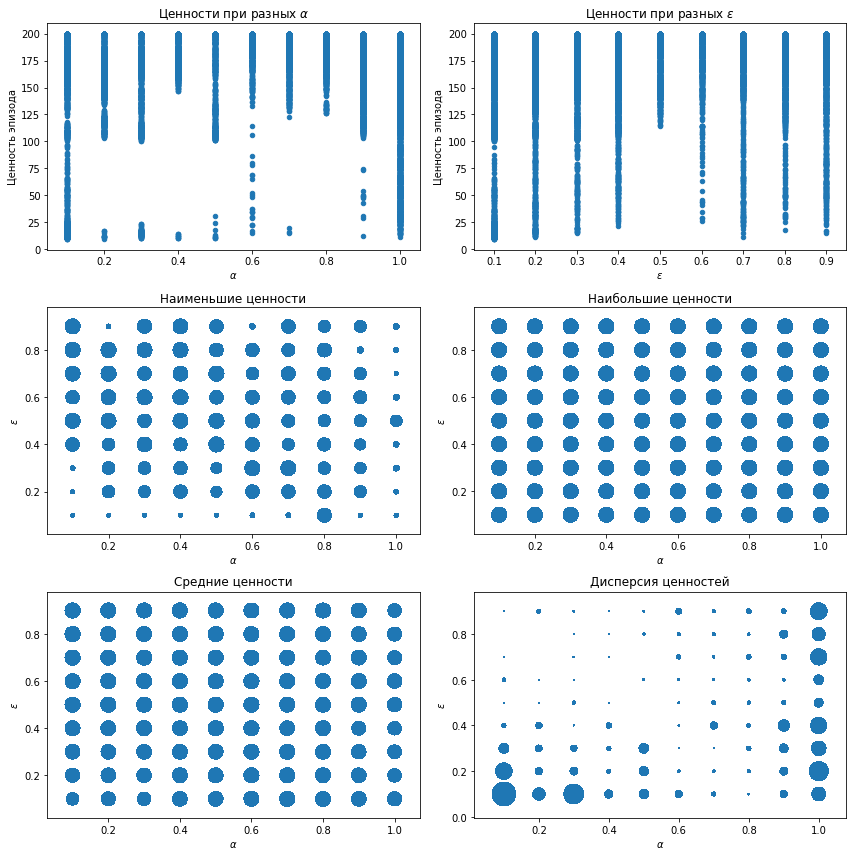

In [25]:
visualize(q_learning_returns_dataframe1)

In [38]:
%%time
alpha = 0.1
gamma = 1
epsilon = 0.5
validation_episodes_count = 100
learning_iterations_count = 2000

q = numpy.zeros((states_count, environment.action_space.n))
q_learning_min_episode_returns = []

for learning_iteration in range(learning_iterations_count):
    q_learning(alpha, gamma, epsilon, q, 1, render=False)
    min_episode_return = numpy.array(q_greedy(gamma, q,
                                               validation_episodes_count,
                                               render=False)).min()
    q_learning_min_episode_returns.append(min_episode_return)
    if (learning_iteration + 1) % (learning_iterations_count // 10) == 0:
        print("Learning iteration " + str(learning_iteration + 1) + " is completed.")

Learning iteration 200 is completed.
Learning iteration 400 is completed.
Learning iteration 600 is completed.
Learning iteration 800 is completed.
Learning iteration 1000 is completed.
Learning iteration 1200 is completed.
Learning iteration 1400 is completed.
Learning iteration 1600 is completed.
Learning iteration 1800 is completed.
Learning iteration 2000 is completed.
CPU times: user 16min 37s, sys: 52 ms, total: 16min 37s
Wall time: 16min 37s


Средняя минимальная ценность: 159.9495


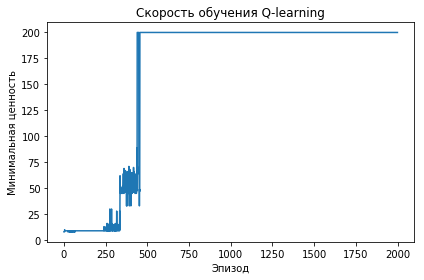

In [39]:
pyplot.plot(q_learning_min_episode_returns)
pyplot.title("Скорость обучения Q-learning")
pyplot.xlabel("Эпизод")
pyplot.ylabel("Минимальная ценность")
pyplot.tight_layout()
print("Средняя минимальная ценность: " + str(numpy.array(q_learning_min_episode_returns).mean()))

Сравним скорости и качество обучения Sarsa и Q-learning.

In [ ]:
pyplot.plot(sarsa_min_episode_returns, label="Sarsa")
pyplot.plot(q_learning_min_episode_returns, label="Q-learning")
pyplot.xlabel("Эпизод")
pyplot.ylabel("Минимальная ценность")
pyplot.title("Скорость обучения")
pyplot.legend()

Как видим, Q-learning обучается быстрее, чем Sarsa. Это связяно с тем, что в формуле обновления значений $Q$ используется не $Q(S_{t+1}, A_{t+1})$, а $\max_aQ(S_{t+1}, a)$, т.е. алгоритм Q-learning более избирательно и стратегически подходит к обновлению значений $Q$.

Обратим внимание, что

$$\max_a Q(S_{t+1}, a) = Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a)).$$

Полагая в правиле обновления для Sarsa

$$Q(S_t, A_t) \gets Q(S_t, A_t) + \alpha\Big[R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)\Big]$$

$A_{t+1} = \arg\max_a Q(S_{t+1}, a)$, получаем правило обновления для Q-learning:

$$\begin{aligned}Q(S_t, A_t) &\gets Q(S_t, A_t) + \alpha\Big[R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a)) - Q(S_t, A_t)\Big] \\ &\gets  Q(S_t, A_t) + \alpha\Big[R_{t+1} + \gamma \max_{a}Q(S_{t+1}, a) - Q(S_t, A_t)\Big].\end{aligned}$$

Заметим, что выражение $A_{t+1} = \arg\max_a Q(S_{t+1}, a)$. вообще говоря, означает выбор действия $A_{t+1}$ в соответствии с жадной стратегией. Действительно, мы запросто из алгоритма Sarsa можем сделать Q-learning, заменив строчку

```python
action2 = epsilon_greedy(q[state2], epsilon)
```

на

```python
action2 = greedy(q[state2])
```

Мы подходим к тому, что, по сути, в алгоритме Q-learning используются две стратегии.

Первая &mdash; *стратегия поведения* (*behavior policy*) &mdash; определяет, какое действие будет выбирать агент на каждом шаге эпизода. В Q-learning мы выбираем действие функцией ```epsilon_greedy```, поэтому *в Q-learning стратегия поведения &mdash; это $\epsilon$-жадная стратегия*.

Вторая &mdash; *целевая стратегия* (*target policy*) &mdash; та, для которой мы оцениваем значения $Q$, т.е. значения $Q$ оценивают ценности при использовании целевой стратегии. Как было сказано выше, в Q-learning мы оцениваем значения $Q$ так, как если бы мы для выбора последующего действия применяли функцию ```greedy```, поэтому *в Q-learning целевая стратегия &mdash; это жадная стратегия*.

При этом *в алгоритме Sarsa целевая стратегия &mdash; это также $\epsilon$-жадная стратегия*, то есть *в алгоритме Sarsa стратегия поведения совпадает с целевой стратегией*.

Методы обучения с подкреплением, в которых стратегия поведения совпадает с целевой стратегией, называют методами с интегрированной оценкой ценности (on-policy methods).

Методы обучения с подкреплением, в которых стратегия поведения отличается от целевой стратегии, называют методами с разделённой оценкой ценности стратегий (off-policy methods).

Таким образом, *алгоритм Sarsa является методом с интегрированной оценкой, а алгоритм Q-learning является методом с разделённой оценкой*.

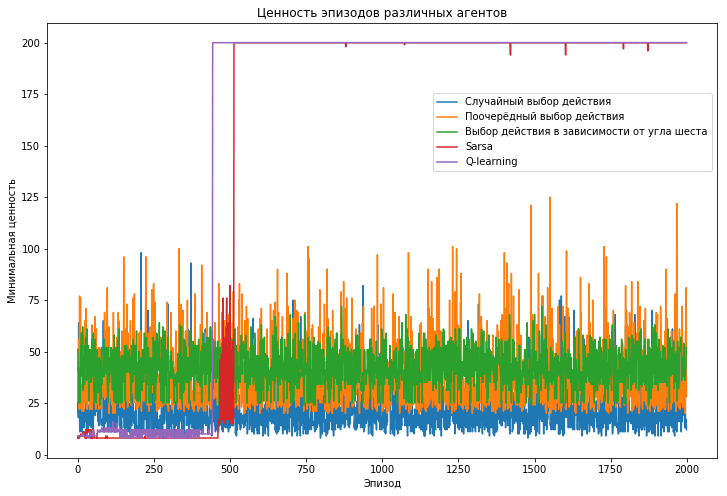

In [50]:
pyplot.figure(figsize=(12, 8))
pyplot.plot(random_episode_returns, label="Случайный выбор действия")
pyplot.plot(switch_episode_returns, label="Поочерёдный выбор действия")
pyplot.plot(angle_episode_returns, label="Выбор действия в зависимости от угла шеста")
pyplot.plot(sarsa_min_episode_returns, label="Sarsa")
pyplot.plot(q_learning_min_episode_returns, label="Q-learning")
pyplot.xlabel("Эпизод")
pyplot.ylabel("Минимальная ценность")
pyplot.title("Ценность эпизодов различных агентов")
pyplot.legend(loc='upper right', bbox_to_anchor=(1, 0.85))

In [0]:
%%time
q_learning_returns_dataframe2 = pandas.DataFrame(columns=["Iteration", "Episode return"])

alpha = 0.1
gamma = 1
epsilon = 0.5
learning_episodes_count = 15000
validation_episodes_count = 100

qs = []
for iteration in range(50):
    q = numpy.zeros((states_count, environment.action_space.n))
    sarsa(alpha, gamma, epsilon, q, learning_episodes_count, render=False)
    episode_returns = q_greedy(gamma, q, validation_episodes_count, render=False)
    for episode_return in episode_returns:
        q_learning_returns_dataframe2.loc[len(q_learning_returns_dataframe2) + 1] \
            = [iteration + 1, episode_return]
    qs.append(q)
    print("Learning iteration " + str(iteration + 1) + " is completed.")

Learning iteration 1 is completed.
Learning iteration 2 is completed.
Learning iteration 3 is completed.
Learning iteration 4 is completed.
Learning iteration 5 is completed.
Learning iteration 6 is completed.
Learning iteration 7 is completed.
Learning iteration 8 is completed.
Learning iteration 9 is completed.
Learning iteration 10 is completed.
Learning iteration 11 is completed.
Learning iteration 12 is completed.
Learning iteration 13 is completed.
Learning iteration 14 is completed.
Learning iteration 15 is completed.
Learning iteration 16 is completed.
Learning iteration 17 is completed.
Learning iteration 18 is completed.
Learning iteration 19 is completed.
Learning iteration 20 is completed.
Learning iteration 21 is completed.
Learning iteration 22 is completed.
Learning iteration 23 is completed.
Learning iteration 24 is completed.
Learning iteration 25 is completed.
Learning iteration 26 is completed.
Learning iteration 27 is completed.
Learning iteration 28 is completed.
L

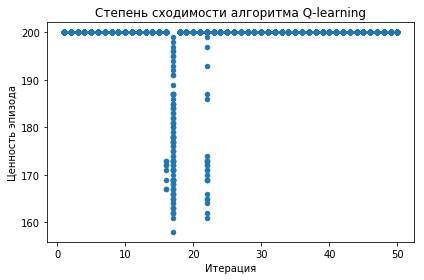

In [0]:
ax = q_learning_returns_dataframe2.plot.scatter(x="Iteration", y="Episode return")
ax.set_title("Степень сходимости алгоритма Q-learning")
ax.set_xlabel("Итерация")
ax.set_ylabel("Ценность эпизода")
pyplot.tight_layout()

Таким образом, табличные методы хоть и неплохо работают, но плохо подходят для данной задачи. Как оказалось, в подобных задачах правильная дискретизация пространства состояний гораздо важнее, чем правильный выбор гиперпараметров или количество обучающих эпизодов. Нам даже пришлось отбросить показатели позиции каретки и скорости каретки, потому что в противном случае количество состояний исчислялось бы сотнями тысяч, то есть при использовании табличных методов мы подвержены *проклятию размерности*.

Далее мы рассмотрим методы глубокого обучения - алгоритмы, в которых вместо таблицы используется модель машинного обучения с весами.

# Глубокое обучение

В табличных методах под большой буквой $Q$ подразумевалась *таблица*, в которой каждая строка - это состояние $s$ в виде некоторого *числа*, а столбец - действие $a$:

$$Q(S_t, A_t).$$

В методах глубокого обучения под $Q$ подразумевается некоторая *функция*, которая принимает в качестве аргументов состояние $s$ в виде некоторого *вектора значений* и действие $a$ и значение которой зависит от значений в *векторе весов* $\theta$:

$$Q(S_t, A_t; \theta).$$

На практике чаще всего реализуют модель машинного обучения, соответствующей функции $Q(S_t; \theta)$, которая возвращает вектор значений $Q$ для каждого действия $A_t$, поэтому функцию $Q(S_t, A_t; \theta)$ следует рассматривать как $A_t$-ую координату вектора, являющегося значением функции $Q(S_t; \theta)$.

## Deep Q-learning

Вводится понятие функции потерь

$$L_t(\theta_t) = \mathbb{E}\Big[(y_t - Q(S_t, A_t; \theta_t))^2\Big],$$

где

$$y_t = \mathbb{E}\Big[R_{t+1} + \gamma \max_a Q(S_{t+1}, a; \theta_{t-1}) \bigm\vert S_t, A_t\Big].$$

Для минимизации функции потерь используется градиентный спуск с градиентом

$$\nabla_{\theta_t}L_t(\theta_t) = \mathbb{E}\Big[\Big(R_{t+1} + \gamma \max_a Q(S_{t+1}, a; \theta_{t-1}) - Q(S_t, A_t; \theta_t)\Big) \nabla_{\theta_t}Q(S_t, A_t; \theta_t)\Big].$$ 

В идеале при кодировании алгоритма индексация при весах $\theta$ должна соблюдаться, то есть должны использоваться две модели: Q-модель, которая предоставляет значение функции $Q(s, a; \theta_i)$; и Target-модель, которая предоставляет значение функции $Q(s', a'; \theta_{i-1})$, т.е. "предыдущую версию" функции $Q$. Впоследствии в определённый момент времени Q-модель становится Target-моделью. На деле же этим нередко пренебрегают и используют одну и ту же модель.

При этом на практике вместо вычисления самого математического ожидания используется стохастический градиентный спуск. Для этого на каждом шаге переход $(S_t, A_t; R_{t+1}, S_{t+1})$ запоминают, помещая его в некоторую структуру данных ("replay memory"). Затем, когда необходимо выполнить градиентный спуск, из этой структуры данных делают случайную выборку определённого объёма, и уже по её значениям проводят градиентный спуск [[3](https://arxiv.org/pdf/1312.5602.pdf)].

Здесь так же, как и в задачах обучения с учителем, можно использовать различные методы улучшения качества модели, например, регуляризацию.

Рассмотрим применение различных моделей машинного обучения в этом алгоритме.

## Линейная модель

In [601]:
from sklearn.linear_model import SGDRegressor

Нам необходимо построить линейную модель, которая бы принимала на вход вектор состояния $S_t$. В нашем случае это вектор из четырёх значений: позиции каретки, скорости каретки, угла наклона шеста и скорости верхушки шеста.

При этом мы должны возвращать вектор значений $Q$ с оценками ценностей для всех возможных действий $A_t$. Вариантов реализации несколько. Например, можно сделать несколько линейных регрессоров. Либо можно использовать один регрессор, но подавать действие как закодированный (например, с помощью one hot encoding) категориальный признак, то есть на вход модели будет подаваться вектор, состоящий из вектора состояния и присоединённого к нему вектора действия. Будем использовать первый вариант.

Создадим несколько всмомогательных функций.

In [671]:
def deep_get_state(observation):
    return numpy.array([observation[2], observation[3]])

def encode(action):
    if action == 0:
        return numpy.array([1, 0])
    else:
        return numpy.array([0, 1])

def get_action_values(q, state):
    action_values = numpy.empty((0))
    for action in [0, 1]:
        X = state.reshape(1, -1)
        action_values = numpy.append(action_values, q[action].predict(X))
    return action_values

def batch(array, samples):
    #return numpy.array(array)[numpy.random.choice(len(array), min(samples, len(array)),
    #                                              replace=False), :]
    return random.sample(array, min(samples, len(array)))

In [672]:
def deep_q_learning(gamma, epsilon, q, episodes, samples, render=False):
    replay_memory = []
    episode_returns = []
    for episode in range(episodes):
        episode_return = 0
        current_discount = 1
        observation = environment.reset()
        state1 = deep_get_state(observation)
        terminated = False
        while not terminated:
            if render:
                environment.render()
            action = epsilon_greedy(get_action_values(q, state1), epsilon)
            observation, reward, terminated, _ = environment.step(action)
            state2 = deep_get_state(observation)
            replay_memory.append((state1, action, reward, state2))
            state1 = state2
            # Sampling minibatch from the replay memory
            for sample_state1, sample_action, sample_reward, sample_state2 \
                in batch(replay_memory, samples):
                X = sample_state1.reshape(1, -1)
                y = [sample_reward + gamma * max(get_action_values(q, sample_state2))]
                q[sample_action].partial_fit(X, y)
            episode_return += current_discount * reward
            current_discount *= gamma
        episode_returns.append(episode_return)
    environment.close()
    return episode_returns

In [673]:
def deep_q_greedy(gamma, q, episodes, render=True):
    episode_returns = []
    for episode in range(episodes):
        episode_return = 0
        current_discount = 1
        observation = environment.reset()
        state = deep_get_state(observation)
        terminated = False
        while not terminated:
            if render:
                environment.render()
            action = greedy(get_action_values(q, state))
            observation, reward, terminated, _ = environment.step(action)
            state = deep_get_state(observation)
            episode_return += current_discount * reward
            current_discount *= gamma
        episode_returns.append(episode_return)
    environment.close()
    return episode_returns

In [689]:
q = [SGDRegressor(), SGDRegressor()]
q[0].fit([[0, 0]], [0])
q[1].fit([[0, 0]], [0])
gamma = 1
epsilon = 0.5
episode_returns = []

/home/gleb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/gleb/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [690]:
%%time
episode_returns.extend(deep_q_learning(gamma, epsilon, q, 1000, 100))

CPU times: user 8min 31s, sys: 699 ms, total: 8min 32s
Wall time: 8min 32s


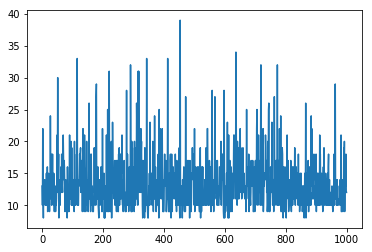

In [691]:
pyplot.plot(episode_returns)

In [692]:
q[0].coef_

array([-7.54689506e+12, -1.22438902e+14])

In [693]:
q[1].coef_

array([-1.63758739e+13, -2.71400614e+14])

In [679]:
deep_q_greedy(gamma, q, 10, render=True)

[1.99609375,
 1.998046875,
 1.9921875,
 1.99609375,
 1.998046875,
 1.9921875,
 1.998046875,
 1.99609375,
 1.9921875,
 1.99609375]